<a href="https://colab.research.google.com/github/ffgama/Cookbook/blob/master/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup do spark no colab

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.4.tgz
!tar xf spark-3.4.0-bin-hadoop3.4.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
!pip install pyspark-pandas

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.4.0-bin-hadoop3.4.tgz: Cannot open: No such file or directory
tar: Error is not recov

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql import types as T
from copy import deepcopy
import pyspark.pandas as ps
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
spark = SparkSession.builder.appName("Fraud Detection App").getOrCreate()

files_names = [
    'train_dataset_recruitment.csv',
    'valid_dataset_recruitment.csv',
    'test_dataset_recruitment.csv'
]

def read_csv_into_spark(filename: str) -> DataFrame:
  """
  Leitura do dataset de treino, teste e validacao.
  """
  drive_path = '/content/drive/MyDrive/ebanx_data/'

  dataset = spark.read.csv(
      drive_path+filename,
      header=True,
      inferSchema=True
  )
  return dataset

def save_csv_into_spark(dataset: DataFrame, path_file: str) -> None:
  """
  Salva em um objeto spark em um arquivo CSV.
  """
  drive_path = '/content/drive/MyDrive/ebanx_data/'

  dataset.write.format("csv") \
    .option("header", True) \
    .option("delimiter", ";") \
    .mode("overwrite") \
    .save(drive_path+path_file)


def checkup_dataset(dataset: DataFrame) -> None:
  """
  Checa e conta o numero de registros nulos nas colunas.
  """
  print(dataset.agg(*(F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in dataset.columns)).show())
  return

def get_general_info_datasets(dataset: DataFrame) -> None:
  """
  Imprime informacoes gerais do dataset.
  """
  print('\n')
  print('--------------------------------------')
  print("Total de {} linhas e {} colunas".format(dataset.count(), len(dataset.columns)))
  print('--------------------------------------')
  print("Schema da tabela:")
  dataset.printSchema()
  dataset.show(2)
  print("Valores nulos do dataset:")
  checkup_dataset(dataset)
  ('--------------------------------------')
  print('Descricao estatistica das features...')
  print(dataset.describe().show())
  ('--------------------------------------')
  return

def get_transformation_to_string(dataset:DataFrame, columns: list) -> DataFrame:
  """
  Converte para string
  """
  for c in columns:
    dataset = dataset.withColumn(c, F.col(c).cast(T.StringType()))

  return dataset



def fill_null_columns(dataset: DataFrame) -> DataFrame:
  """
  Responsavel por substituir valores nulos presente em uma coluna.
  """
  string_columns = ['fakeTransactionId','fakeCustomerEmail',
                    'fakeCardId', 'fakeCustomerPhone','fakeCustomerIp','fakeBillingZip',
                    'billingCity','billingState','billingCountry']

  dataset = dataset.fillna("Sem preenchimento", subset=string_columns)

  date_columns = ['customerDob', 'customerCreatedAt', 'cbkDate', 'dt']
  date_to_replace = '1900-01-01'

  for column in date_columns:
    dataset = dataset.withColumn(
        column, F.to_date(F.date_format(F.coalesce(F.col(column),  F.lit('1900-01-01')), "yyyy-MM-dd"))
  )

  return dataset

# Carga de Dados

In [4]:
# Carga de dados
train_df, val_df, test_df = [read_csv_into_spark(f) for f in files_names]

In [5]:
# Datasets info
get_general_info_datasets(train_df)



--------------------------------------
Total de 2826 linhas e 16 colunas
--------------------------------------
Schema da tabela:
root
 |-- fakeTransactionId: string (nullable = true)
 |-- logDate: timestamp (nullable = true)
 |-- fakeCustomerEmail: string (nullable = true)
 |-- fakeCardId: string (nullable = true)
 |-- fakeCustomerPhone: string (nullable = true)
 |-- fakeCustomerIp: string (nullable = true)
 |-- fakeBillingZip: string (nullable = true)
 |-- customerDob: date (nullable = true)
 |-- customerCreatedAt: date (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- billingCity: string (nullable = true)
 |-- billingState: string (nullable = true)
 |-- billingCountry: string (nullable = true)
 |-- isCbk: integer (nullable = true)
 |-- cbkDate: date (nullable = true)
 |-- dt: date (nullable = true)

+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------

# Transformacao de dados

Duas colunas nao existem nos dados de teste: o target **isCbk** e a coluna **cbkDate**. A primeira, preencheremos a medida que disponibilizarmos os resultados da predicao. Enquanto que a segunda poderiamos excluir porem optamos em manter pelo menos provisoriamente pensando que ela possa eventualmente ser util para nos ajudar a compor alguma outra variavel presente no dataset.

A avaliacao abaixo e necessaria para garantirmos que ao tentar prever o fenomeno tenhamos acesso as variveis do mundo real.

In [6]:
# checando features que nao estao presentes nos datasets
load_all_cols = set(train_df.columns).union(test_df.columns).union(val_df.columns)
common_cols = set(train_df.columns).intersection(test_df.columns).intersection(val_df.columns)
distinct_cols = load_all_cols - common_cols
distinct_cols

{'cbkDate', 'isCbk'}

In [7]:
# criando as duas colunas no teste apenas para facilitar na execucao das etapas seguintes
test_df_add = test_df.withColumn("cbkDate", F.lit('-')) \
        .withColumn("isCbk", F.lit(None))

In [8]:
# substituindo registros nao preenchidos
train_df_cleaned = fill_null_columns(train_df)
val_df_cleaned = fill_null_columns(val_df)
test_df_cleaned = fill_null_columns(test_df_add)

In [9]:
checkup_dataset(train_df_cleaned)
checkup_dataset(val_df_cleaned)
checkup_dataset(test_df_cleaned)

+-----------------+-------+-----------------+----------+-----------------+--------------+--------------+-----------+-----------------+-----------+-----------+------------+--------------+-----+-------+---+
|fakeTransactionId|logDate|fakeCustomerEmail|fakeCardId|fakeCustomerPhone|fakeCustomerIp|fakeBillingZip|customerDob|customerCreatedAt|totalAmount|billingCity|billingState|billingCountry|isCbk|cbkDate| dt|
+-----------------+-------+-----------------+----------+-----------------+--------------+--------------+-----------+-----------------+-----------+-----------+------------+--------------+-----+-------+---+
|                0|      0|                0|         0|                0|             0|             0|          0|                0|          0|          0|           0|             0|    0|      0|  0|
+-----------------+-------+-----------------+----------+-----------------+--------------+--------------+-----------+-----------------+-----------+-----------+------------+---------

Aplicando as transformacoes minimas

In [10]:
train_df_cleaned_transf = get_transformation_to_string(train_df_cleaned, columns=['isCbk'])
val_df_cleaned_transf = get_transformation_to_string(val_df_cleaned, columns=['isCbk'])
test_df_cleaned_transf = get_transformation_to_string(test_df_cleaned, columns=['isCbk'])

Salvando os resultados intermediarios...

In [11]:
save_csv_into_spark(train_df_cleaned_transf, 'eda_data/train_df_cleaned_transf.csv')
save_csv_into_spark(val_df_cleaned_transf, 'eda_data/val_df_cleaned_transf.csv')
save_csv_into_spark(test_df_cleaned_transf, 'eda_data/test_df_cleaned_transf.csv')

# EDA basico

In [12]:
# file_names = ['eda_data/train_df_cleaned_transf.csv', 'eda_data/val_df_cleaned_transf.csv','eda_data/test_df_cleaned_transf.csv']
# Carga de dados
# train_eda, val_eda, test_eda = [read_csv_into_spark(f) for f in files_names]
train_eda, val_eda, test_eda = train_df_cleaned_transf, val_df_cleaned_transf, test_df_cleaned_transf

Avaliando a cardinalidade das features categoricas. E possivel notar que tanto **fakeTransactionId** quanto **logDate** do jeito que estao nos fornecem pouca informacao sobre o evento. Porem, a segunda pode nos ajudar no trabalho de enriquecimento de features. **Billing Country** tem valores constantes e tambem podemos remover.

In [13]:
print('Treino={}'.format(train_eda.count()))
print('Validacao={}'.format(val_eda.count()))
print('Teste={}'.format(test_eda.count()))
print('> Listando eventos unicos ...')
print(train_eda.agg(*(F.countDistinct(F.col(col)).alias(col) for col in train_eda.columns)).collect()[0])
print(val_eda.agg(*(F.countDistinct(F.col(col)).alias(col) for col in val_eda.columns)).collect()[0])
print(test_eda.agg(*(F.countDistinct(F.col(col)).alias(col) for col in test_eda.columns)).collect()[0])

Treino=2826
Validacao=2828
Teste=2835
> Listando eventos unicos ...
Row(fakeTransactionId=2826, logDate=2823, fakeCustomerEmail=315, fakeCardId=622, fakeCustomerPhone=407, fakeCustomerIp=338, fakeBillingZip=382, customerDob=368, customerCreatedAt=290, totalAmount=716, billingCity=174, billingState=25, billingCountry=1, isCbk=2, cbkDate=27, dt=37)
Row(fakeTransactionId=2828, logDate=2826, fakeCustomerEmail=315, fakeCardId=581, fakeCustomerPhone=370, fakeCustomerIp=259, fakeBillingZip=361, customerDob=357, customerCreatedAt=282, totalAmount=588, billingCity=166, billingState=26, billingCountry=1, isCbk=2, cbkDate=29, dt=37)
Row(fakeTransactionId=2835, logDate=2829, fakeCustomerEmail=315, fakeCardId=455, fakeCustomerPhone=350, fakeCustomerIp=101, fakeBillingZip=339, customerDob=402, customerCreatedAt=270, totalAmount=248, billingCity=192, billingState=28, billingCountry=1, dt=33, cbkDate=0, isCbk=0)


Compreendendo a relacao das features com o target. Abaixo notamos que o target de fato e extremamente desbalanceado com cenario identico nos datasets de treino e validacao.

In [14]:
df_prop_train = train_eda.groupBy('isCbk')\
                  .agg(F.count('isCbk').alias('Tot'),
                      (F.count('isCbk') / train_eda.count()).alias('Prop')
)
df_prop_train.show()

df_prop_val = val_eda.groupBy('isCbk')\
                      .agg(F.count('isCbk').alias('Tot'),
                          (F.count('isCbk') / val_eda.count()).alias('Prop')
)

df_prop_val.show()

# caso desejemos visualizar
# df_prop_train = ps.DataFrame(df_prop_train)
# df_prop_train.plot.pie(y='Prop')

+-----+----+--------------------+
|isCbk| Tot|                Prop|
+-----+----+--------------------+
|    0|2757|   0.975583864118896|
|    1|  69|0.024416135881104035|
+-----+----+--------------------+

+-----+----+--------------------+
|isCbk| Tot|                Prop|
+-----+----+--------------------+
|    0|2760|  0.9759547383309759|
|    1|  68|0.024045261669024046|
+-----+----+--------------------+




**Variaveis numericas**

Gostariamos de investigar se ha alguma diferenca entre no evento de fraude vs nao fraude para as variaveis numericas. No nosso caso, a unica que temos e o valor de transacao. No conjunto de validacao as magnitudes mudam mas o comportamento e muito similar.

**Valor da transacao**

In [15]:
train_eda.groupBy('isCbk')\
        .agg(F.median('totalAmount').alias('Med.'),
             F.mean('totalAmount').alias('Avg.')).show()

val_eda.groupBy('isCbk')\
        .agg(F.median('totalAmount').alias('Med.'),
             F.mean('totalAmount').alias('Avg.')).show()

+-----+----+------------------+
|isCbk|Med.|              Avg.|
+-----+----+------------------+
|    0|26.0|  87.6016938701475|
|    1|80.2|122.88811594202902|
+-----+----+------------------+

+-----+------+------------------+
|isCbk|  Med.|              Avg.|
+-----+------+------------------+
|    0|  34.9| 70.23455434782474|
|    1|99.875|146.33632352941174|
+-----+------+------------------+



Media e mediana indicam que o saldo e maior quando ha fraude. Em geral a distribuicao de ambos eventos eh similar na presenca dessa variavel. Mas dentro do evento fraude parece temos uma leve distribuicao bicaudal o que indica que a presenca de uma outra variavel pode ajudar a explicar melhor o fenomeno.

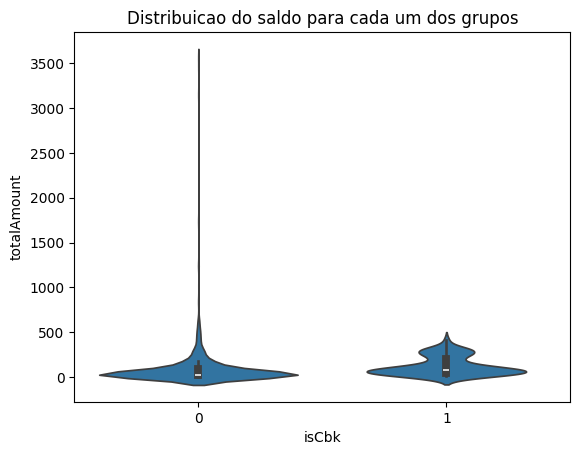

In [16]:
sns.violinplot(x='isCbk', y='totalAmount', data=train_eda.toPandas().sort_values('isCbk'))
plt.title("Distribuicao do saldo para cada um dos grupos")
plt.show()

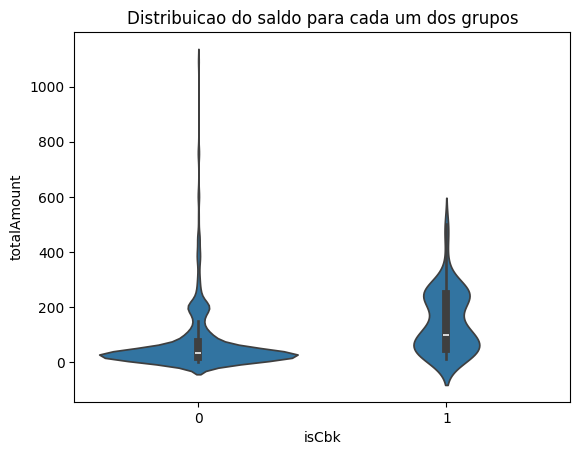

In [17]:
sns.violinplot(x='isCbk', y='totalAmount', data=val_eda.toPandas().sort_values('isCbk'))
plt.title("Distribuicao do saldo para cada um dos grupos")
plt.show()

**Variaveis categoricas**

Dentro do universo categorico vamos comecar explorando as features espaciais.

**Estado de cobranca do titular**

In [18]:
# train_eda.filter(F.col('billingState')=='Sem preenchimento').show()

Estados situados no Norte, Nordeste e Sul lideram o ranking de casos de fraude.

In [19]:
table_prop = train_eda.groupBy('billingState')\
          .agg(F.count('isCbk').alias('tot'),
               F.sum('isCbk').alias('soma')) \
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot'))*100,2))

table_prop\
  .filter(F.col('billingState')!='Sem preenchimento')\
  .orderBy(F.desc('Prop'))\
  .show(30)

+------------+----+----+-----+
|billingState| tot|soma| Prop|
+------------+----+----+-----+
|          AC|   6| 3.0| 50.0|
|          TO|  15| 7.0|46.67|
|          PI|  12| 3.0| 25.0|
|          SC| 124|10.0| 8.06|
|          RS| 153|10.0| 6.54|
|          BA| 135| 5.0|  3.7|
|          PE| 124| 4.0| 3.23|
|          RJ| 284| 9.0| 3.17|
|          MG| 224| 5.0| 2.23|
|          ES|  64| 1.0| 1.56|
|          SP|1012|12.0| 1.19|
|          RO|  27| 0.0|  0.0|
|          AM|  18| 0.0|  0.0|
|          GO|  90| 0.0|  0.0|
|          MT|   9| 0.0|  0.0|
|          PB|  27| 0.0|  0.0|
|          MS|  18| 0.0|  0.0|
|          AL|  20| 0.0|  0.0|
|          PA|  54| 0.0|  0.0|
|          SE|   9| 0.0|  0.0|
|          CE|  90| 0.0|  0.0|
|          RN|   9| 0.0|  0.0|
|          DF|  68| 0.0|  0.0|
|          PR| 216| 0.0|  0.0|
+------------+----+----+-----+



**Cidade de cobranca do titular**

Perda de informacoes relevante por nao termos cidades com registros preenchidos. Existem algumas opcoes a mesa que poderiamos utilizar na etapa de feature engineering como, por exemplo, rotular registros com base nas informacoes do estado aumentando o numero de exemplos disponiveis em cada cidade utilizando alguma estrategia de labelling como preencher com base na cidade mais frequente. Tambem temos a opcao de deixar como esta assumindo que o nao preenchimento desse campo ja representa  por si so um padrao disponiveis que pdoe ser util na modelagem.

In [20]:
train_eda.filter(F.col('billingCity')=='Sem preenchimento').show(3)

+--------------------+-------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------+-----------------+-----------+-----------------+------------+--------------+-----+----------+----------+
|   fakeTransactionId|            logDate|   fakeCustomerEmail|          fakeCardId|   fakeCustomerPhone|   fakeCustomerIp|      fakeBillingZip|customerDob|customerCreatedAt|totalAmount|      billingCity|billingState|billingCountry|isCbk|   cbkDate|        dt|
+--------------------+-------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------+-----------------+-----------+-----------------+------------+--------------+-----+----------+----------+
|063fa90a-6338-46c...|2021-05-16 00:32:29|091acc56-a4ea-4b0...|f9880882-26bd-450...|a7d10b70-0796-484...|Sem preenchimento|0e6f1728-b515-4dd...| 1991-11-12|       2021-01-29|      59.22|Sem preenchimento|          SP|

In [21]:
train_eda.filter(F.col('billingCity')=='Sem preenchimento')\
        .groupBy('billingState')\
        .agg(F.count('billingState').alias('tot'),
            F.sum('isCbk').alias('soma')) \
        .withColumn('Prop', F.round((F.col('soma') / F.col('tot'))*100,2))\
        .orderBy(F.desc('Prop'))\
        .show()

+-----------------+---+----+-----+
|     billingState|tot|soma| Prop|
+-----------------+---+----+-----+
|               PI|  3| 3.0|100.0|
|               TO|  6| 2.0|33.33|
|               BA| 18| 5.0|27.78|
|               RS| 44| 5.0|11.36|
|               SC| 54| 5.0| 9.26|
|               MG| 70| 5.0| 7.14|
|               SP|276| 8.0|  2.9|
|               AM|  9| 0.0|  0.0|
|               GO| 36| 0.0|  0.0|
|Sem preenchimento| 18| 0.0|  0.0|
|               ES|  4| 0.0|  0.0|
|               MS| 16| 0.0|  0.0|
|               AL|  9| 0.0|  0.0|
|               PA|  9| 0.0|  0.0|
|               PE| 23| 0.0|  0.0|
|               CE| 36| 0.0|  0.0|
|               RJ| 91| 0.0|  0.0|
|               DF| 18| 0.0|  0.0|
|               PR| 44| 0.0|  0.0|
+-----------------+---+----+-----+



Avaliando a frequencia/proporcao de registros por cidade.

In [22]:
table_prop = train_eda.groupBy('billingCity')\
          .agg(F.count('isCbk').alias('tot'),
               F.sum('isCbk').alias('soma')) \
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot'))*100,2))

table_prop.orderBy(F.desc('Prop')).show(30)

+--------------------+---+----+-----+
|         billingCity|tot|soma| Prop|
+--------------------+---+----+-----+
|          sao mateus|  7| 4.0|57.14|
|                taio|  9| 5.0|55.56|
|              palmas|  9| 5.0|55.56|
|        porto alegre| 17| 5.0|29.41|
|             diadema| 24| 4.0|16.67|
|              recife| 43| 4.0|  9.3|
|      rio de janeiro| 99| 9.0| 9.09|
|   Sem preenchimento|784|33.0| 4.21|
|           igrejinha|  9| 0.0|  0.0|
|  cachoeira paulista|  9| 0.0|  0.0|
|            itanhaem|  9| 0.0|  0.0|
|              araras|  9| 0.0|  0.0|
|             solanea|  9| 0.0|  0.0|
|              santos|  6| 0.0|  0.0|
|          votorantim|  9| 0.0|  0.0|
|              trairi|  9| 0.0|  0.0|
|conselheiro lafaiete|  9| 0.0|  0.0|
|      venancio aires|  9| 0.0|  0.0|
|           aparecida|  9| 0.0|  0.0|
|         teresopolis|  9| 0.0|  0.0|
|      antonio carlos|  2| 0.0|  0.0|
|                  rj|  4| 0.0|  0.0|
|             pelotas|  9| 0.0|  0.0|
|          s

**Data de criacao de conta (cliente)**

Faremos breves analises em variaveis de data, porem esse tipo de dado representa uma riqueza muito grande na por ser uma variavel composta com padroes autocontidos ou mesmo que podem ser combinados a outras variaveis de data presentes no dataset. O foco nesse case nao e fazer uma analise profunda buscando por interrelacoes mas apenas compreender o que temos em maos antes da modelagem.

In [23]:
train_eda.select('customerCreatedAt').distinct()

DataFrame[customerCreatedAt: date]

Contagem do numero de eventos fraudulentos para contas criadas no mesmo dia.

In [24]:
table_prop = train_eda.groupBy('customerCreatedAt')\
          .agg(F.count('isCbk').alias('tot'),
               F.sum('isCbk').alias('soma')) \
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot'))*100,2))

table_prop.orderBy(F.desc('Prop')).show(30)

+-----------------+---+----+-----+
|customerCreatedAt|tot|soma| Prop|
+-----------------+---+----+-----+
|       2020-09-04|  9| 5.0|55.56|
|       2021-05-10|  9| 5.0|55.56|
|       2017-09-19|  9| 5.0|55.56|
|       2017-12-30|  9| 5.0|55.56|
|       2020-10-22|  9| 5.0|55.56|
|       2021-05-22|  9| 5.0|55.56|
|       2019-10-06|  9| 5.0|55.56|
|       2021-05-02|  9| 5.0|55.56|
|       2021-05-25|  9| 5.0|55.56|
|       2021-04-28|  8| 4.0| 50.0|
|       2019-09-20|  9| 4.0|44.44|
|       2021-05-26| 23| 8.0|34.78|
|       2020-12-12| 16| 4.0| 25.0|
|       2015-01-21| 16| 4.0| 25.0|
|       2019-06-04|  9| 0.0|  0.0|
|       2015-05-19|  9| 0.0|  0.0|
|       2018-10-05|  9| 0.0|  0.0|
|       2015-04-09|  9| 0.0|  0.0|
|       2020-08-28|  9| 0.0|  0.0|
|       2021-05-12|  9| 0.0|  0.0|
|       2015-03-12|  9| 0.0|  0.0|
|       2017-06-29|  9| 0.0|  0.0|
|       2017-09-29|  9| 0.0|  0.0|
|       2019-01-08| 18| 0.0|  0.0|
|       2017-12-02|  9| 0.0|  0.0|
|       2019-10-05| 

Ano de 2021 registrou maior numero de contas criadas com registros de eventos fraudulentos.


In [25]:
train_eda = train_eda.withColumn('year_customerCreatedAt', F.year(train_eda['customerCreatedAt']))
train_eda.groupBy('year_customerCreatedAt')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy('year_customerCreatedAt')\
          .show()

+----------------------+-----------+----+----+
|year_customerCreatedAt|tot_eventos|soma|Prop|
+----------------------+-----------+----+----+
|                  2013|          9| 0.0| 0.0|
|                  2014|        144| 0.0| 0.0|
|                  2015|        205| 4.0|1.95|
|                  2016|        207| 0.0| 0.0|
|                  2017|        441|10.0|2.27|
|                  2018|        432| 0.0| 0.0|
|                  2019|        405| 9.0|2.22|
|                  2020|        502|14.0|2.79|
|                  2021|        481|32.0|6.65|
+----------------------+-----------+----+----+



Contas criadas nos meses Maio, Setembro, Outubro e Dezembro apontam um maior percentual de registros fraudulentos. Talvez isso tenha tambem alguma relacao com o calendario varejista. De repente, podemos ter uma feature relavante.

In [26]:
train_eda = train_eda.withColumn('month_customerCreatedAt', F.month(train_eda['customerCreatedAt']))
train_eda.groupBy('month_customerCreatedAt')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy('month_customerCreatedAt')\
          .show()

+-----------------------+-----------+----+----+
|month_customerCreatedAt|tot_eventos|soma|Prop|
+-----------------------+-----------+----+----+
|                      1|        268| 4.0|1.49|
|                      2|        189| 0.0| 0.0|
|                      3|        207| 0.0| 0.0|
|                      4|        260| 4.0|1.54|
|                      5|        419|28.0|6.68|
|                      6|        180| 0.0| 0.0|
|                      7|        171| 0.0| 0.0|
|                      8|        180| 0.0| 0.0|
|                      9|        198|14.0|7.07|
|                     10|        234|10.0|4.27|
|                     11|        279| 0.0| 0.0|
|                     12|        241| 9.0|3.73|
+-----------------------+-----------+----+----+



Notamos que contas criadas em alguns dias especificos do mes tiveram uma proporcao maior de eventos positivos. Bem como existem alguns dias com 0 sinistralidade.

In [27]:
train_eda = train_eda.withColumn('day_customerCreatedAt', F.day(train_eda['customerCreatedAt']))
train_eda.groupBy('day_customerCreatedAt')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy('day_customerCreatedAt')\
          .show(31)

+---------------------+-----------+----+----+
|day_customerCreatedAt|tot_eventos|soma|Prop|
+---------------------+-----------+----+----+
|                    1|         54| 0.0| 0.0|
|                    2|        126| 5.0|3.97|
|                    3|         99| 0.0| 0.0|
|                    4|        108| 5.0|4.63|
|                    5|         54| 0.0| 0.0|
|                    6|         72| 5.0|6.94|
|                    7|         99| 0.0| 0.0|
|                    8|        135| 0.0| 0.0|
|                    9|         99| 0.0| 0.0|
|                   10|         81| 5.0|6.17|
|                   11|         72| 0.0| 0.0|
|                   12|        106| 4.0|3.77|
|                   13|         99| 0.0| 0.0|
|                   14|         99| 0.0| 0.0|
|                   15|        108| 0.0| 0.0|
|                   16|        135| 0.0| 0.0|
|                   17|        108| 0.0| 0.0|
|                   18|         45| 0.0| 0.0|
|                   19|         72

Por dia da semana

In [28]:
train_eda = train_eda.withColumn('semana_customerCreatedAt', F.dayofweek(train_eda['customerCreatedAt']))
train_eda.groupBy('semana_customerCreatedAt')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy('semana_customerCreatedAt')\
          .show()

+------------------------+-----------+----+----+
|semana_customerCreatedAt|tot_eventos|soma|Prop|
+------------------------+-----------+----+----+
|                       1|        315|10.0|3.17|
|                       2|        369| 5.0|1.36|
|                       3|        378|10.0|2.65|
|                       4|        425|16.0|3.76|
|                       5|        351| 5.0|1.42|
|                       6|        468| 9.0|1.92|
|                       7|        520|14.0|2.69|
+------------------------+-----------+----+----+



**Data de ocorrencia da transacao**

In [29]:
train_eda.show(3)

+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------------+-----------+-----------+------------+--------------+-----+----------+----------+----------------------+-----------------------+---------------------+------------------------+
|   fakeTransactionId|            logDate|   fakeCustomerEmail|          fakeCardId|   fakeCustomerPhone|      fakeCustomerIp|      fakeBillingZip|customerDob|customerCreatedAt|totalAmount|billingCity|billingState|billingCountry|isCbk|   cbkDate|        dt|year_customerCreatedAt|month_customerCreatedAt|day_customerCreatedAt|semana_customerCreatedAt|
+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------------+-----------+-----------+------------+--------------+-----+----------+----------+----------------------+----------------

Todos os dados de data da transacao de sao do ano de 2021. Cujo periodo e de 25/04 a 31/05 desse mesmo ano. No dataset de validacao o periodo as observacoes estao entre 25/08 a 30/09. Enquanto que nos dados de teste o periodo e de 29/09 a 31/10. Em todos os casos janelas de pouco mais de 30 dias.

Quinta e sexta-feira sao os **dias da semana** com menores indices de ocorrencia. Um aprofundamento mais interessante seria uma analise feature a feature das suas distribuicoes nos datasets de treino, validacao e teste o que estenderia essa analise mais do que precisamos nessa primeira interacao.

In [30]:
train_eda = train_eda.withColumn('semana_dt', F.dayofweek(train_eda['dt']))
train_eda.groupBy('semana_dt')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy('semana_dt')\
          .show()

+---------+-----------+----+----+
|semana_dt|tot_eventos|soma|Prop|
+---------+-----------+----+----+
|        1|        399|13.0|3.26|
|        2|        407| 9.0|2.21|
|        3|        358|11.0|3.07|
|        4|        529|18.0| 3.4|
|        5|        329| 2.0|0.61|
|        6|        414| 4.0|0.97|
|        7|        390|12.0|3.08|
+---------+-----------+----+----+



In [31]:
train_eda = train_eda.withColumn('dia_dt', F.day(train_eda['dt']))
train_eda.groupBy('dia_dt')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy('dia_dt')\
          .show(31)

+------+-----------+----+-----+
|dia_dt|tot_eventos|soma| Prop|
+------+-----------+----+-----+
|     1|         62| 0.0|  0.0|
|     2|         59| 1.0| 1.69|
|     3|         73| 4.0| 5.48|
|     4|         66| 0.0|  0.0|
|     5|         65| 5.0| 7.69|
|     6|         72| 1.0| 1.39|
|     7|        158| 3.0|  1.9|
|     8|        103| 0.0|  0.0|
|     9|         59| 4.0| 6.78|
|    10|         63| 5.0| 7.94|
|    11|         52| 0.0|  0.0|
|    12|         50| 0.0|  0.0|
|    13|         53| 0.0|  0.0|
|    14|         57| 0.0|  0.0|
|    15|         70| 0.0|  0.0|
|    16|         73| 0.0|  0.0|
|    17|         78| 0.0|  0.0|
|    18|         88| 2.0| 2.27|
|    19|        152| 0.0|  0.0|
|    20|         82| 0.0|  0.0|
|    21|         61| 1.0| 1.64|
|    22|         79|10.0|12.66|
|    23|         84| 2.0| 2.38|
|    24|         70| 0.0|  0.0|
|    25|        150|10.0| 6.67|
|    26|        236| 9.0| 3.81|
|    27|        140| 1.0| 0.71|
|    28|        162| 4.0| 2.47|
|    29|

**Data de nascimento dos clientes**

A partir da data de nascimento podemos extrair uma informacao mais contextual: a idade do cliente. A partir dessa feature podemos discretizar em muitas outras conforme a necessidade. Por exemplo, ao segmentarmos por faixa etaria encontramos que grupos de clientes 40+ tendem a sofrer mais fraude. Ou melhor ainda, conforme a faixa etaria aumenta maior a tendencia de sofrer fraude.

In [32]:
train_eda = train_eda.withColumn('idade',
                                 F.round(F.date_diff(F.current_date(),
                                                     train_eda['customerDob'])/365, 0).cast(T.IntegerType())
                                )\
                      .withColumn('faixa_etaria', F.when(F.col('idade')<=29, '[0,29]')\
                                                  .when(F.col('idade').between(30,40), '[30,40]')\
                                                  .when(F.col('idade')>40, '40+')
                                  )
train_eda.groupBy('faixa_etaria')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2)) \
          .orderBy('faixa_etaria')\
          .show(100)

+------------+-----------+----+----+
|faixa_etaria|tot_eventos|soma|Prop|
+------------+-----------+----+----+
|         40+|       1108|35.0|3.16|
|      [0,29]|        875|17.0|1.94|
|     [30,40]|        843|17.0|2.02|
+------------+-----------+----+----+



Uma rapida inspecionada no conjunto de validacao ratifica a tese acima. Portanto, temos uma variavel hot que pode ser explorada na modelagem.

In [33]:
val_eda = val_eda.withColumn('idade',
                                 F.round(F.date_diff(F.current_date(),
                                                     val_eda['customerDob'])/365, 0).cast(T.IntegerType())
                                )\
                      .withColumn('faixa_etaria', F.when(F.col('idade')<=29, '[0,29]')\
                                                  .when(F.col('idade').between(30,40), '[30,40]')\
                                                  .when(F.col('idade')>40, '40+')
                                  )
val_eda.groupBy('faixa_etaria')\
          .agg(F.count('isCbk').alias('tot_eventos'),
               F.sum('isCbk').alias('soma'))\
          .withColumn(
              'Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2)) \
          .orderBy('faixa_etaria')\
          .show(100)

+------------+-----------+----+----+
|faixa_etaria|tot_eventos|soma|Prop|
+------------+-----------+----+----+
|         40+|        939|53.0|5.64|
|      [0,29]|       1188| 6.0|0.51|
|     [30,40]|        701| 9.0|1.28|
+------------+-----------+----+----+



**Codigo Postal do cliente**

A granularidade dessa variavel pode ser util para prever o target. Porem, o risco de overfitting ou mesmo sermos afetados com a maldicao da dimensionalidade e evidente. Temos um baixo numero de exemplos para cada categoria. Idealmente poderiamos splitar esses campos na tentativa de agrega-lo e assim combatermos esse risco.

Mesmo com alguns splits na coluna nao chegamos em um agrupamento interessante. Temos poucos registros com um volume razoavel de registros. Mas com bons indicativos de potenciais alvos.

In [34]:
df_count = train_eda.groupBy('fakeBillingZip')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))

df_count.show(2)

train_eda.withColumn('Zip01', F.split(train_eda['fakeBillingZip'], "-").getItem(0))\
          .withColumn('Zip02', F.split(train_eda['fakeBillingZip'], "-").getItem(1))\
          .withColumn('Zip03', F.split(train_eda['fakeBillingZip'], "-").getItem(2))\
          .withColumn('Zip04', F.split(train_eda['fakeBillingZip'], "-").getItem(3))\
          .groupBy('Zip03')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))\
          .show(30)

+--------------------+-----------+
|      fakeBillingZip|tot_eventos|
+--------------------+-----------+
|   Sem preenchimento|         45|
|36a2b506-60a3-41f...|          9|
+--------------------+-----------+
only showing top 2 rows

+-----+-----------+
|Zip03|tot_eventos|
+-----+-----------+
| NULL|         45|
| 4404|         27|
| 46bd|         18|
| 4fe4|         18|
| 4dd6|         18|
| 477e|         18|
| 4990|         16|
| 47ae|         16|
| 45e8|         13|
| 4d50|         12|
| 430e|         11|
| 4ab5|         11|
| 4f7a|         10|
| 4f33|         10|
| 49f3|         10|
| 4565|          9|
| 4977|          9|
| 437e|          9|
| 4e87|          9|
| 4d6c|          9|
| 40df|          9|
| 4ce4|          9|
| 44f5|          9|
| 48ce|          9|
| 4236|          9|
| 451d|          9|
| 49f6|          9|
| 42df|          9|
| 4736|          9|
| 4531|          9|
+-----+-----------+
only showing top 30 rows



**Ip de localizacao dos clientes**

Tambem pode nos fornecer uma informacao espacial necessaria para prever o target. Porem muitos valores nulos e alta cardinalidade.

In [35]:
df_count = train_eda.groupBy('fakeCustomerIp')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))

train_eda.withColumn('Ip01', F.split(train_eda['fakeCustomerIp'], "-").getItem(0))\
          .withColumn('Ip02', F.split(train_eda['fakeCustomerIp'], "-").getItem(1))\
          .withColumn('Ip03', F.split(train_eda['fakeCustomerIp'], "-").getItem(2))\
          .withColumn('Ip04', F.split(train_eda['fakeCustomerIp'], "-").getItem(3))\
          .withColumn('Ip05', F.split(train_eda['fakeCustomerIp'], "-").getItem(4))\
          .groupBy('Ip05')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))\
          .show(30)

# df_count.show()

+------------+-----------+
|        Ip05|tot_eventos|
+------------+-----------+
|        NULL|       1984|
|f91531c1752b|          9|
|394c81c59bb3|          9|
|be92d2ea5c7f|          9|
|32a0757de3f3|          9|
|b4fe119c6bfe|          9|
|6b4ea00ae510|          9|
|bdf9d9f29462|          9|
|ba8b8d15875c|          9|
|e1df8b2bea44|          9|
|086491ff8836|          9|
|b8edf86994d3|          9|
|2515cc81ec29|          9|
|494c770c6df3|          9|
|b41b4134fee3|          9|
|5fe97a7639f0|          9|
|e4c94d72c920|          9|
|769294fd8a97|          8|
|45b5e14f0a96|          8|
|173b46c13850|          7|
|130cc981938c|          7|
|defc445a6a1b|          7|
|6331c934e942|          7|
|f316219ad895|          7|
|7a18885f88e7|          7|
|837bde61f63d|          7|
|30e1862be942|          7|
|ab9f9ac2ae5f|          7|
|6a057e1e807e|          6|
|32b1c613a346|          6|
+------------+-----------+
only showing top 30 rows



**Telefone do cliente**

Tal como os casos acima o telefone (especialmente DDD) do cliente pode nos dar pistas sobre localizacao.

In [36]:
df_count = train_eda.groupBy('fakeCustomerPhone')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))
df_count.show(5)

ps.DataFrame(df_count)

train_eda.withColumn('Phone01', F.split(train_eda['fakeCustomerPhone'], "-").getItem(0))\
          .withColumn('Phone02', F.split(train_eda['fakeCustomerPhone'], "-").getItem(1))\
          .withColumn('Phone03', F.split(train_eda['fakeCustomerPhone'], "-").getItem(2))\
          .withColumn('Phone04', F.split(train_eda['fakeCustomerPhone'], "-").getItem(3))\
          .withColumn('Phone05', F.split(train_eda['fakeCustomerPhone'], "-").getItem(4))\
          .groupBy('Phone03')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))\
          .show(30)

+--------------------+-----------+
|   fakeCustomerPhone|tot_eventos|
+--------------------+-----------+
|3c51b456-d58d-47d...|          9|
|e756a698-d531-40f...|          9|
|073766a2-534c-494...|          9|
|7dbaaa5b-048a-4d8...|          9|
|155eb3d8-1678-478...|          9|
+--------------------+-----------+
only showing top 5 rows

+-------+-----------+
|Phone03|tot_eventos|
+-------+-----------+
|   47e7|         18|
|   4d74|         18|
|   4687|         18|
|   4fa1|         15|
|   4c9d|         14|
|   4208|         14|
|   4ca4|         13|
|   4095|         13|
|   4bc3|         11|
|   40a6|         10|
|   4fdc|         10|
|   49a5|         10|
|   4a76|         10|
|   403a|          9|
|   4a82|          9|
|   4e47|          9|
|   46e3|          9|
|   4cd5|          9|
|   46f3|          9|
|   4b80|          9|
|   4f39|          9|
|   4782|          9|
|   4fdb|          9|
|   43ca|          9|
|   47d1|          9|
|   4fa0|          9|
|   4d83|          9|


**Cartao do cliente**

In [37]:
df_count = train_eda.groupBy('fakeCardId')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))
df_count.show(5)

ps.DataFrame(df_count).head(2)

train_eda.withColumn('card01', F.split(train_eda['fakeCardId'], "-").getItem(0))\
          .withColumn('card02', F.split(train_eda['fakeCardId'], "-").getItem(1))\
          .withColumn('card03', F.split(train_eda['fakeCardId'], "-").getItem(2))\
          .withColumn('card04', F.split(train_eda['fakeCardId'], "-").getItem(3))\
          .withColumn('card05', F.split(train_eda['fakeCardId'], "-").getItem(4))\
          .groupBy('card05')\
          .agg(F.count('isCbk').alias('tot_eventos'))\
          .orderBy(F.desc('tot_eventos'))\
          .show(30)

+--------------------+-----------+
|          fakeCardId|tot_eventos|
+--------------------+-----------+
|85b956a3-313a-426...|          9|
|537c3272-06ca-4ef...|          9|
|e253b99b-ebf1-43a...|          9|
|6fb5c571-51c9-419...|          9|
|bc880606-d5fa-4fe...|          9|
+--------------------+-----------+
only showing top 5 rows

+------------+-----------+
|      card05|tot_eventos|
+------------+-----------+
|ba976ae2ac06|          9|
|bf5c4ccccf68|          9|
|22dd78a4817b|          9|
|3a8b41148e69|          9|
|cd584366352b|          9|
|9022b904c139|          9|
|6c837f125e6e|          9|
|0a9bcd103979|          9|
|5d031a57ada2|          9|
|b39de102c389|          9|
|718ca1ad2528|          9|
|e8346d6c6552|          9|
|2ef36ac8a616|          9|
|36dd4a8024a9|          9|
|3134caacfca1|          9|
|beb4bb77f277|          9|
|d7e3dd6eabf1|          9|
|0065c224479f|          9|
|8c82415b8133|          9|
|6269b615d860|          9|
|fbc2d7ba23c0|          9|
|075e4ae99f7

**Dia/Hora da transacao**

Podemos extrair informacoes com uma granularidade muito maior avaliando momentos ao longo do dia que propiciam a ocorrencia de fraude. Podemos compor com muitas features a partir desta.

Por exemplo, o periodo da manha proporcionamente contem mais registros de fraudes. O que, de certa forma, pode desafiar o senso comum. Mas se combinarmos esse fato com uma padrao de pequenos valores de transacoes ao longo do dia (dentre outros fatores) temos um comportamento que comeca a fazer sentido.

In [38]:
train_eda = train_eda\
            .withColumn('hora_logDate', F.hour(train_eda['logDate']))\
            .withColumn('minuto_logDate', F.minute(train_eda['logDate']))\
            .withColumn('segundo_logDate', F.second(train_eda['logDate']))\
            .withColumn('hora_minuto_logDate', F.concat_ws(':', F.hour(train_eda['logDate']), F.minute(train_eda['logDate'])))\
            .withColumn('periodo_dia_logDate', F.when(F.col('hora_logDate').between(0,5), 'Madrugada')\
                                                .when(F.col('hora_logDate').between(6,13), 'Manha')\
                                                .when(F.col('hora_logDate').between(13,19), 'Tarde')\
                                                .when(F.col('hora_logDate').between(19,23), 'Noite')
                        )
train_eda.groupBy('periodo_dia_logDate')\
          .agg(F.count('isCbk').alias('tot_eventos'), F.sum('isCbk').alias('soma'))\
          .withColumn('Prop', F.round((F.col('soma') / F.col('tot_eventos'))*100,2))\
          .orderBy(F.desc('Prop'))\
          .show()

+-------------------+-----------+----+----+
|periodo_dia_logDate|tot_eventos|soma|Prop|
+-------------------+-----------+----+----+
|              Manha|        386|16.0|4.15|
|              Tarde|        940|24.0|2.55|
|              Noite|        745|19.0|2.55|
|          Madrugada|        755|10.0|1.32|
+-------------------+-----------+----+----+



Hora de preparar os dados para a etapa de modelagem.

# Preparacao de dados: etapa pre-modelagem

In [39]:
def remove_columns_from_df(dataset: DataFrame, columns: list) -> DataFrame:
  """
  Remove uma n colunas de um dataset.
  """
  dataset = dataset.drop(*[c for c in columns])
  return dataset


def create_new_columns_from_date(dataset: DataFrame, timestamp_columns: list, date_columns: list) -> DataFrame:
  """
  Cria novas features a partir de colunas do tipo data.
  """

  for c in timestamp_columns:
    dataset = dataset\
              .withColumn('ano_'+c, F.year(dataset[c]))\
              .withColumn('mes_'+c, F.month(dataset[c]))\
              .withColumn('dia_'+c, F.day(dataset[c]))\
              .withColumn('dia_semana_'+c, F.dayofweek(dataset[c]))\
              .withColumn('hora_'+c, F.hour(dataset[c]))\
              .withColumn('minuto_'+c, F.minute(dataset[c]))\
              .withColumn('segundo_'+c, F.second(dataset[c]))\
              .withColumn('hora_minuto_'+c, F.concat_ws(':', F.hour(dataset[c]), F.minute(dataset[c])))\
              .withColumn('periodo_dia_'+c, F.when(F.col('hora_'+c).between(0,5), 'Madrugada')\
                                                  .when(F.col('hora_'+c).between(6,13), 'Manha')\
                                                  .when(F.col('hora_'+c).between(13,19), 'Tarde')\
                                                  .when(F.col('hora_'+c).between(19,23), 'Noite'))\
              .withColumn('periodo_dia_'+c, F.when(F.col('dia_semana_'+c).between(6,7), 'Final de semana')\
                                                  .otherwise('Semana')
              )

  for c in date_columns:
    dataset = dataset\
              .withColumn('ano_'+c, F.year(dataset[c]))\
              .withColumn('mes_'+c, F.month(dataset[c]))\
              .withColumn('dia_'+c, F.day(dataset[c]))\
              .withColumn('dia_semana_'+c, F.dayofweek(dataset[c]))\
              .withColumn('periodo_dia_'+c, F.when(F.col('dia_semana_'+c).between(6,7), 'Final de semana')\
                                                      .otherwise('Semana')
                  )

  return dataset


def create_new_fields_dt_nascimento(dataset: DataFrame, col_nasc: str) -> DataFrame:
    """
    Criando novas features a partir da data de nascimento.
    """

    dataset = dataset.withColumn('idade', F.round(F.date_diff(F.current_date(),
                                                              dataset['customerDob'])/365, 0)\
                      .cast(T.IntegerType()))\
                      .withColumn('faixa_etaria', F.when(F.col('idade')<=29, '[0,29]')\
                                                  .when(F.col('idade').between(30,40), '[30,40]')\
                                                  .when(F.col('idade')>40, '40+'))

    return dataset

def create_new_fields_based_compound_fields(dataset: DataFrame, columns: list) -> DataFrame:
    """
    Split de campos compostos.
    """

    for col in columns:
      dataset = dataset.withColumn(col+'_01',F.split(dataset[col], "-").getItem(0))\
                      .withColumn(col+'_02', F.split(dataset[col], "-").getItem(1))\
                      .withColumn(col+'_03', F.split(dataset[col], "-").getItem(2))\
                      .withColumn(col+'_04', F.split(dataset[col], "-").getItem(3))\
                      .withColumn(col+'_05', F.split(dataset[col], "-").getItem(4))
    return dataset

**Deletando features**

In [40]:
cols_to_delete = ['fakeTransactionId','billingCountry','cbkDate']
train_df_prepared = remove_columns_from_df(train_df_cleaned_transf, columns=cols_to_delete)
val_df_prepared = remove_columns_from_df(val_df_cleaned_transf, columns=cols_to_delete)
test_df_prepared = remove_columns_from_df(test_df_cleaned_transf, columns=cols_to_delete)

**Criacao de novas features**

In [41]:
timestamp_cols = ['logDate']
date_cols = ['dt', 'customerCreatedAt']
train_df_prepared = create_new_columns_from_date(train_df_prepared,
    timestamp_columns=timestamp_cols,
    date_columns=date_cols)

val_df_prepared = create_new_columns_from_date(val_df_cleaned_transf,
    timestamp_columns=timestamp_cols,
    date_columns=date_cols)

test_df_prepared = create_new_columns_from_date(test_df_prepared,
    timestamp_columns=timestamp_cols,
    date_columns=date_cols)


**Campo nascimento**

In [42]:
train_df_prepared = create_new_fields_dt_nascimento(train_df_prepared, col_nasc = 'customerDob')
val_df_prepared = create_new_fields_dt_nascimento(val_df_prepared, col_nasc = 'customerDob')
test_df_prepared = create_new_fields_dt_nascimento(test_df_prepared, col_nasc = 'customerDob')

**Outros campos categoricos**

In [43]:
compound_cols = ['fakeCustomerEmail','fakeCardId', 'fakeCustomerPhone', 'fakeCustomerIp', 'fakeBillingZip']
train_df_prepared = create_new_fields_based_compound_fields(train_df_prepared, columns=compound_cols)
val_df_prepared = create_new_fields_based_compound_fields(val_df_prepared, columns=compound_cols)
test_df_prepared = create_new_fields_based_compound_fields(test_df_prepared, columns=compound_cols)

In [44]:
train_df_prepared.show(2)

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------------+-----------+-----------+------------+-----+----------+-----------+-----------+-----------+------------------+------------+--------------+---------------+-------------------+-------------------+------+------+------+-------------+--------------+---------------------+---------------------+---------------------+----------------------------+-----------------------------+-----+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------------

In [45]:
cols_not_selected = ['logDate', 'fakeCustomerEmail','fakeCardId',
                     'fakeCustomerPhone','fakeCustomerIp','fakeBillingZip', 'customerDob',
                     'customerCreatedAt']

train_df_selected = train_df_prepared\
          .select([col for col in train_df_prepared.columns if col not in cols_not_selected])
val_df_selected = val_df_prepared\
          .select([col for col in val_df_prepared.columns if col not in cols_not_selected])
test_df_selected = test_df_prepared\
          .select([col for col in test_df_prepared.columns if col not in cols_not_selected])

In [46]:
train_df_selected = train_df_selected.fillna("Sem prenchimento")
val_df_selected = val_df_selected.fillna("Sem prenchimento")
test_df_selected = test_df_selected.fillna("Sem prenchimento")

In [47]:
train_df_selected.show(3)

+-----------+-----------+------------+-----+----------+-----------+-----------+-----------+------------------+------------+--------------+---------------+-------------------+-------------------+------+------+------+-------------+--------------+---------------------+---------------------+---------------------+----------------------------+-----------------------------+-----+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|totalAmount|billingCity|billingState|isCbk|        dt|ano_logDate|mes_logDate|dia_logDate|dia_semana_logDate|hora_logDate|minuto_logDate|segundo_logDa

**Salvando registros....**

In [48]:
save_csv_into_spark(train_df_selected, 'ml_data/train_df_prepared.csv')
save_csv_into_spark(val_df_selected, 'ml_data/val_df_prepared.csv')
save_csv_into_spark(test_df_selected, 'ml_data/test_df_prepared.csv')

# Etapa de Modelagem: Parte 1

Tentamos utilizar o Spark MLlib para lidar com todo o processo de modelagem. Encontramos problemas ao longo da caminho especialmente com a lentidao na etapa de treinamento do modelo. A lib tambem nao tem suporte nativo a alguns recursos importantes para busca dos melhores hiperparametros utilizando otimizacao bayesiana por ex. ou mesmo metricas de avaliacao de modelos.


Dessa forma, podemos considerar toda essa parte 1 como opcional. Pois iremos seguir para uma modelagem utilizando as proprias libs da linguagem python.

In [49]:
# file_names = ['ml_data/train_df_prepared.csv', 'ml_data/val_df_prepared.csv','ml_data/test_df_prepared.csv']
# Carga de dados
# train_data, val_data, test_data = [read_csv_into_spark(f) for f in files_names]
train_data, val_data, test_data = train_df_selected, val_df_selected, test_df_selected

In [50]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

cols_to_select = ['isCbk', 'totalAmount','mes_logDate', 'dia_logDate', 'dia_semana_logDate',
                  'hora_logDate', 'ano_customerCreatedAt',
                  'mes_customerCreatedAt', 'dia_customerCreatedAt', 'idade', 'faixa_etaria',
                  'billingState','periodo_dia_logDate']
filter_train_data = train_data.select(cols_to_select)
filter_val_data = val_data.select(cols_to_select)
filter_train_data.show(2)

+-----+-----------+-----------+-----------+------------------+------------+---------------------+---------------------+---------------------+-----+------------+------------+-------------------+
|isCbk|totalAmount|mes_logDate|dia_logDate|dia_semana_logDate|hora_logDate|ano_customerCreatedAt|mes_customerCreatedAt|dia_customerCreatedAt|idade|faixa_etaria|billingState|periodo_dia_logDate|
+-----+-----------+-----------+-----------+------------------+------------+---------------------+---------------------+---------------------+-----+------------+------------+-------------------+
|    0|       16.9|          5|         18|                 3|          12|                 2015|                   11|                    3|   27|      [0,29]|          SP|             Semana|
|    0|      34.84|          5|         19|                 4|          15|                 2015|                   11|                    3|   27|      [0,29]|          SP|             Semana|
+-----+-----------+-----------

Definindo os ranges dos hiperparametros.

In [51]:
negative_class = filter_train_data.filter(F.col('isCbk')==0).count()
positive_class = filter_train_data.filter(F.col('isCbk')==1).count()

ref_pos_weight = np.round(negative_class/positive_class)
start = int(ref_pos_weight * .9)
end = int(ref_pos_weight // .9)
interval_class_pos_weight = list(range(start, end+1))
interval_max_depth = [5,10,15]
interval_eta = [0.001, 0.01]
interval_col_sample_by_tree = [0.3, 0.4, 0.5]
interval_subsample = [0.6, 0.7]
interval_alpha = [1e-5, 1e-2, 0.1]

## Tunning: validacao train/test

In [52]:
# num_features = ['totalAmount']

# # features que tem uma ordem natural
# cat_features_order = ['faixa_etaria', 'periodo_dia_logDate', 'dia_semana_logDate', 'mes_logDate','dia_logDate','hora_logDate',
#                 'ano_customerCreatedAt','mes_customerCreatedAt','dia_customerCreatedAt']

# # fatures que a ordem nao importa
# cat_features = ['billingState']

# targetIndexer = StringIndexer(inputCol='isCbk', outputCol='isCbkIndex', handleInvalid='keep')

# indexers = [StringIndexer(inputCol=c, outputCol="{}_indexed".format(c), handleInvalid='keep') for c in cat_features_order]

# indexers_enc = [StringIndexer(inputCol=c, outputCol="{}_indexed_encoded".format(c), handleInvalid='keep') for c in cat_features]

# encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
#                           outputCol="{}_encoded".format(indexer.getOutputCol())) for indexer in indexers_enc]

# assemblerInputs = [c + "_indexed_encoded" for c in cat_features] + [c + "_indexed" for c in cat_features_order] + [c for c in num_features]
# assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

# xgb = SparkXGBClassifier(
#     features_col='features',
#     label_col='isCbk',
#     prediction_col='prediction',
#     numRound=100
# )

# pipeline = Pipeline(stages=indexers + indexers_enc + encoders + [targetIndexer, assembler, xgb])

# # Create a ParamGridBuilder to specify the parameters to cross-validate
# param_grid = ParamGridBuilder()\
#           .addGrid(xgb.max_depth, interval_max_depth) \
#           .addGrid(xgb.scale_pos_weight, interval_class_pos_weight)\
#           .addGrid(xgb.learning_rate, interval_eta)\
#           .addGrid(xgb.colsample_bytree, interval_col_sample_by_tree)\
#           .addGrid(xgb.subsample, interval_col_sample_by_tree)\
#           .addGrid(xgb.reg_alpha, interval_alpha)\
#           .build()


# evaluator = BinaryClassificationEvaluator(
#     labelCol='isCbkIndex',
#     rawPredictionCol='prediction',
#     metricName='areaUnderPR'
# )

# tvsplit = TrainValidationSplit(
#     estimator=pipeline,
#     estimatorParamMaps=param_grid,
#     evaluator=evaluator,
#     trainRatio=0.7
# )


# # Train the cross-validator
# model = tvsplit.fit(filter_train_data)

# # # model = pipeline.fit(filter_train_data)
# # prediction = model_cv.transform(filter_val_data)

# # # Definindo o avaliador
# # evaluator = BinaryClassificationEvaluator(
# #     labelCol='isCbkIndex',
# #     predictionCol='prediction',
# #     metricName='f1', beta=1.0
# # )

# # # Definindo as metricas
# # f1 = evaluator.evaluate(prediction, {evaluator.metricName: 'f1'})
# # weightedPrecision = evaluator.evaluate(prediction, {evaluator.metricName: 'weightedPrecision'})
# # weightedRecall = evaluator.evaluate(prediction, {evaluator.metricName: 'weightedRecall'})

# # # Avaliando o modelo
# # print('\n=======================')
# # print('F1 Score = {}'.format(np.round(f1, 4)))
# # print('Weighted Precision = {}'.format(np.round(weightedPrecision, 4)))
# # print('Weighted Recall = {}'.format(np.round(weightedRecall, 4)))

In [53]:
# # Evaluate the best model on the test data
# prediction = tvsplit.transform(filter_val_data)

# # f1 = evaluator.evaluate(prediction, {evaluator.metricName: 'f1'})
# areaUnderPR = evaluator.evaluate(prediction, {evaluator.metricName: 'areaUnderPR'})

# # Print the results
# print(f"Area Under Precision/Recall: {areaUnderPR}")

## Tunning: CV (Opcional nesse caso)
Opcao secundaria por ser extremamente custosa para o algoritmo. Soma-se isso o fato do pyspark ml nao oferecer suporte nativo a uma alternativa muito mais interessante que seria a estratificacao baseada em otimizacao bayesiana o que baratearia muito o custo da busca dos hiperparametros.

In [54]:
num_features = ['totalAmount']

# features que tem uma ordem natural
cat_features_order = ['faixa_etaria', 'periodo_dia_logDate', 'dia_semana_logDate', 'mes_logDate','dia_logDate','hora_logDate',
                'ano_customerCreatedAt','mes_customerCreatedAt','dia_customerCreatedAt']

# fatures que a ordem nao importa
cat_features = ['billingState']

targetIndexer = StringIndexer(inputCol='isCbk', outputCol='isCbkIndex', handleInvalid='keep')

indexers = [StringIndexer(inputCol=c, outputCol="{}_indexed".format(c), handleInvalid='keep') for c in cat_features_order]

indexers_enc = [StringIndexer(inputCol=c, outputCol="{}_indexed_encoded".format(c), handleInvalid='keep') for c in cat_features]

encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                          outputCol="{}_encoded".format(indexer.getOutputCol())) for indexer in indexers_enc]

assemblerInputs = [c + "_indexed_encoded" for c in cat_features] + [c + "_indexed" for c in cat_features_order] + [c for c in num_features]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

xgb = SparkXGBClassifier(
    features_col='features',
    label_col='isCbk',
    prediction_col='prediction',
    numRound=100
)

pipeline = Pipeline(stages=indexers + indexers_enc + encoders + [targetIndexer, assembler, xgb])

# Create a ParamGridBuilder to specify the parameters to cross-validate
param_grid = ParamGridBuilder()\
          .addGrid(xgb.max_depth, interval_max_depth) \
          .addGrid(xgb.scale_pos_weight, interval_class_pos_weight)\
          .addGrid(xgb.learning_rate, interval_eta)\
          .addGrid(xgb.colsample_bytree, interval_col_sample_by_tree)\
          .addGrid(xgb.subsample, interval_col_sample_by_tree)\
          .addGrid(xgb.reg_alpha, interval_alpha)\
          .build()


evaluator = BinaryClassificationEvaluator(
    labelCol='isCbkIndex',
    rawPredictionCol='prediction',
    metricName='areaUnderPR'
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator = evaluator,
    numFolds=3
)

# Train the cross-validator
model_cv = cv.fit(filter_train_data)

In [55]:
# printando os melhores hiperparametros
model_cv.bestModel.stages[-1].extractParamMap()

In [56]:
# Evaluate the best model on the test data
prediction = model_cv.transform(filter_val_data)

# f1 = evaluator.evaluate(prediction, {evaluator.metricName: 'f1'})
areaUnderPR = evaluator.evaluate(prediction, {evaluator.metricName: 'areaUnderPR'})

# Print the results
print(f"Area Under Precision/Recall: {areaUnderPR}")

## Avaliacao do modelo

In [57]:
# df_select_pred = prediction.select("isCbkIndex", "prediction", "probability")
# # df_select_pred.filter(F.col('IsCbkIndex')==1).toPandas()

# tp = df_select_pred.where(df_select_pred["isCbkIndex"] == 1).where(df_select_pred["prediction"] == 1).count()
# tn = df_select_pred.where(df_select_pred["isCbkIndex"] == 0).where(df_select_pred["prediction"] == 0).count()
# fp = df_select_pred.where(df_select_pred["isCbkIndex"] == 0).where(df_select_pred["prediction"] == 1).count()
# fn = df_select_pred.where(df_select_pred["isCbkIndex"] == 1).where(df_select_pred["prediction"] == 0).count()

# print('TP = {}'.format(tp))
# print('TN = {}'.format(tn))
# print('FP = {}'.format(fp))
# print('FN = {}'.format(fn))

# print('Recall = {}'.format(tp/(tp+fn)))
# print('Precision = {}'.format(tp/(tp+fp)))

In [58]:
# Fazendo previsões no conjunto de teste
# predictions = model.transform(filter_val_data)
# filtered_prediction = predictions.limit(10000)
# Count the number of missing values per column
# missing_counts = filtered_prediction.agg(*(F.count(F.col(c)).alias(c) for c in filtered_prediction.columns))
# Print the results
# missing_counts.show()
# predictions.show(110)
# predictions.head(1)

# Etapa de modelagem: Parte 2

Como dito acima seguiremos toda nossa etapa de construcao do modelo de ML utilizando python nativo para isso precisamos converter o objeto spark em um dataframe do pandas.

In [59]:
!pip install scikit-optimize

In [114]:
from sklearn.pipeline import Pipeline
import pandas as pd
# from collections import Counter
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import f1_score, make_scorer, classification_report, r2_score
import warnings
import time

warnings.filterwarnings("ignore")

In [115]:
train_data, val_data, test_data = train_df_selected.toPandas(), val_df_selected.toPandas(), test_df_selected.toPandas()

In [116]:
cols_to_select = ['isCbk', 'totalAmount','mes_logDate', 'dia_logDate', 'dia_semana_logDate',
                  'hora_logDate', 'ano_customerCreatedAt',
                  'mes_customerCreatedAt', 'dia_customerCreatedAt', 'idade', 'faixa_etaria',
                  'billingState','periodo_dia_logDate']

filter_train_data = train_data[cols_to_select]
filter_val_data = val_data[cols_to_select]
filter_train_data.head(2)

,isCbk,totalAmount,mes_logDate,dia_logDate,dia_semana_logDate,hora_logDate,ano_customerCreatedAt,mes_customerCreatedAt,dia_customerCreatedAt,idade,faixa_etaria,billingState,periodo_dia_logDate
0,0,16.90,5,18,3,12,2015,11,3,27,"[0,29]",SP,Semana
1,0,34.84,5,19,4,15,2015,11,3,27,"[0,29]",SP,Semana


In [118]:
def convert_datatypes(dataset: DataFrame):
  int_list = ['isCbk']
  category_list = ['mes_logDate', 'dia_logDate', 'dia_semana_logDate',
                   'hora_logDate', 'ano_customerCreatedAt', 'mes_customerCreatedAt','dia_customerCreatedAt',
                   'idade', 'faixa_etaria', 'billingState','periodo_dia_logDate','periodo_dia_logDate']

  for ci in int_list:
    dataset.loc[:, ci] = dataset[ci].astype(int)

  for cl in category_list:
    dataset.loc[:, cl] = dataset[cl].astype('category')

  return dataset

filter_train_data = convert_datatypes(filter_train_data)
filter_val_data = convert_datatypes(filter_val_data)

In [119]:
target = ['isCbk']

X_train, y_train = (
    filter_train_data.drop(target, axis=1), filter_train_data[target]
)

X_test, y_test = (
    filter_val_data.drop(target, axis=1), filter_val_data[target]
)

**Versao 1: Baseline model** utilizando todos os parametros default

In [120]:
# start_time = time.time()
base_params = {}

pipeline = Pipeline([
    ('xgb',  XGBClassifier(**base_params, enable_categorical=True))
])

pipeline.fit(X_train, y_train)

# end_time = time.time()
# print('Tempo de execucao = {}s' .format(np.round(end_time - start_time)))

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

**AVALIACAO: Versao 1 do modelo**

In [121]:
predictions_xgb = pipeline.predict(X_test)
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2760
           1       0.00      0.00      0.00        68

    accuracy                           0.97      2828
   macro avg       0.49      0.50      0.49      2828
weighted avg       0.95      0.97      0.96      2828



In [122]:
y_test_df = pd.DataFrame(y_test)
predictions_xgb_df = pd.DataFrame(predictions_xgb).rename(columns={0:'isCbk_pred'})
results_df = pd.concat([y_test_df, predictions_xgb_df], axis=1)

In [123]:
query_template = "isCbk_pred==1 and isCbk==1"
results_df.query(query_template)

,isCbk,isCbk_pred


**Versao 2: ajuste de alguns parametros** utilizando todos os parametros default

In [124]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train['isCbk'])
class_weights

array([ 0.5125136 , 20.47826087])

In [136]:
xgb_params = {
    "class_weight": {0: class_weights[0], 1: class_weights[1]},
    "n_estimators": 300,
    "learning_rate": 0.01,
    "max_depth": 15,
    "min_child_weight": 2,
    # "subsample": 1.0,
    # "colsample_bytree": 1.0,
    # "gamma": 2,
    "reg_lambda": 1,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    # "random_state": 42,
}

pipeline = Pipeline([
    ('xgb',  XGBClassifier(**xgb_params, use_label_encoder=False, enable_categorical=True))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight={0: 0.5125136017410229,
                                             1: 20.47826086956522},
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [137]:
predictions_xgb = pipeline.predict(X_test)
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2760
           1       0.00      0.00      0.00        68

    accuracy                           0.97      2828
   macro avg       0.49      0.50      0.49      2828
weighted avg       0.95      0.97      0.96      2828



Otimizacao de hiperparametros

In [138]:
import numpy as np
parameters = {
    'xgb__n_estimators': Integer(100, 300),
    'xgb__max_depth': Integer(5, 15),
    'xgb__learning_rate': Real(0.01, 1.0, 'log-uniform')
}

# Definindo a função objetivo
f1_scorer = make_scorer(f1_score)

# Realizando a busca dos melhores parâmetros
bayes_search = BayesSearchCV(pipeline, parameters, scoring=f1_scorer, n_jobs=-1, n_iter=50, cv=5)
# bayes_search.fit(X_train, y_train)

In [139]:
bayes_search.fit(X_train, y_train)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations